# Logistic Regression from Scratch 
### Compare models trained using:
- **Gradient calculated by Analytical method**
- **Gradient calculated by Central Difference Formula**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import numpy as np

### Generate data using mean and covariates
- so that we are free to generate linearly separable and non-linearly separable data 

In [71]:
def generate_data():
    mean1 = [-1, 2]
    mean3 = [-1.5, 2.5]
    mean2 = [0, 1]
    mean4 = [0.5, 1.5]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 100)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 100)))
    y2 = np.zeros(len(X2)) 
    return X1, y1, X2, y2

X1, y1, X2, y2 = generate_data()
X = np.concatenate((X1, X2))
Y = np.concatenate((y1,y2))

df = pd.DataFrame({'X1':X[:,0], 'X2':X[:,1], 'y':Y})

### Divide into train and test

In [73]:
df_train = df.groupby('y', group_keys=False).apply(lambda x:x.sample(frac=0.7))
df_train = df_train.sample(frac=1) # to distribute data randomly
df_test = df[~df.index.isin(df_train.index)]

In [74]:
X_train = df_train[['X1', 'X2']]
X_test = df_test[['X1', 'X2']]
y_train = df_train['y']
y_test = df_test['y']

Text(0.5, 1.0, 'Train Data')

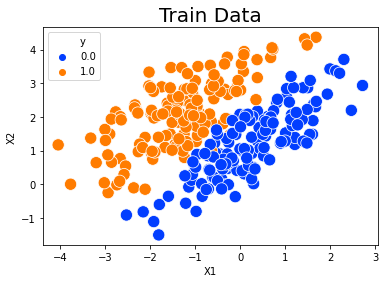

In [80]:
sns.set_palette('bright')
ax = sns.scatterplot(data = df_train, x ='X1', y='X2', hue='y', s=150,cmap='RdBu')
ax.set_title('Train Data', size=20)

Text(0.5, 1.0, 'Test Data')

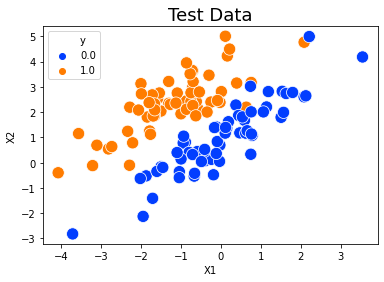

In [82]:
ax = sns.scatterplot(data = df_test, x ='X1', y='X2', hue='y', s=150,cmap='RdBu')
ax.set_title('Test Data', size=18)

In [192]:
class LogisticRegression_:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def __gradient(self, X, y, theta):
        z = np.dot(X, theta)
        h = self.__sigmoid(z)
        return np.dot(X.T, (h - y)) / y.size
    
    # Gradient using Central Difference Formula
    # Gradient = [f(x + delta_x) - f(x - delta_x)] / 2*delta_x
    def __cdf_Gradient(self, X, y, theta, del_theta):
        n = len(self.theta)
        grad = np.zeros(n)
        del_theta = 0.001
        for i in range(n):
            a = theta
            a[i] = theta[i] + del_theta
            z_f = np.dot(X, a)
            h_f = self.__sigmoid(z_f)
            a[i] = theta[i] - del_theta
            z_b = np.dot(X, a)
            h_b = self.__sigmoid(z_b)
            grad[i] = (self.__loss(h_f, y) - self.__loss(h_b, y))/(2*del_theta)
        return grad
        
        
    def fit(self, X, y, method='gradient'):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # initialize weights
        self.theta = np.zeros(X.shape[1])
        for i in range(self.num_iter):   
            if method=='gradient':
                grad = self.__gradient(X, y, self.theta)
            if method=='cdf_gradient':
                grad = self.__cdf_Gradient(X,y, self.theta, 0.01)
            self.theta = self.theta - self.lr * grad
                
        return self.theta
    
    # Calculate Probability
    def predict_proba(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold):
        return self.predict_proba(X) >= threshold

In [193]:
def plot_prob_contour(model):
   # continuous grid of values and evaluate the probability of each (x, y) point in the grid
    x_min, x_max = X_test['X1'].min() - .5, X_test['X1'].max() + .5
    y_min, y_max = X_test['X2'].min() - .5, X_test['X2'].max() + .5

    xx, yy = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    try:
        probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)
    except:
        probs = model.predict_proba(grid).reshape(xx.shape)

    # plot the probability grid as a contour map 
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X_test['X1'], X_test['X2'], c=y_test[:], s=100,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(aspect="equal",
           xlim=(x_min, x_max), ylim=(y_min, y_max),
           xlabel="$X_1$", ylabel="$X_2$")
    ax.set_title('Contour probability plot', size=18)

### With gradient calculated by Analytical Method

In [194]:
model_ = LogisticRegression_(lr=0.1, num_iter=1000)
%time coeff = model_.fit(X_train, y_train, method='gradient')
print('coeff = ', coeff_)
accuracy = (model_.predict(X_test, 0.5)==y_test).mean()
print('Accuracy = ', accuracy)
prob = model_.predict_proba(X_test)
loss = (-y_test * np.log(prob) - (1 - y_test) * np.log(1 - prob)).mean()
print('Loss = ', loss)

Wall time: 156 ms
coeff =  [-4.49847184 -2.6390848   2.10391871]
Accuracy =  0.975
Loss =  0.1403143324641531


#### Decision Boundary

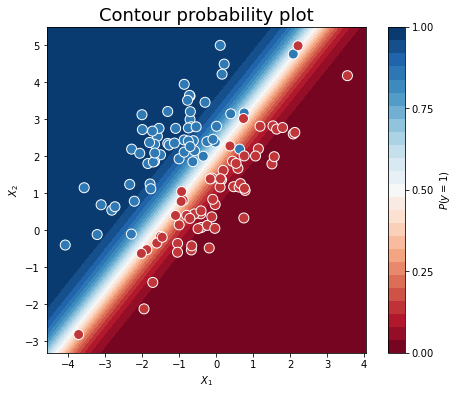

In [195]:
plot_prob_contour(model_)

**Let's consolidate our findings**

In [196]:
results = []
results.append(['Analytical Method',accuracy,loss, coeff[1:], coeff[0]])

### With gradient calculated by Central Difference Formula

In [198]:
model_ = LogisticRegression_(lr=0.1, num_iter=1000)
%time coeff = model_.fit(X_train, y_train, method='cdf_gradient')
print('coeff = ', coeff)

accuracy = (model_.predict(X_test, 0.5)==y_test).mean()
print('Accuracy = ', accuracy)

prob = model_.predict_proba(X_test)
loss = (-y_test * np.log(prob) - (1 - y_test) * np.log(1 - prob)).mean()

results.append(['Central Differece Formula',accuracy,loss, coeff[1:], coeff[0]])

Wall time: 3.66 s
coeff =  [-3.17553795 -2.04386878  1.50515965]
Accuracy =  0.9583333333333334


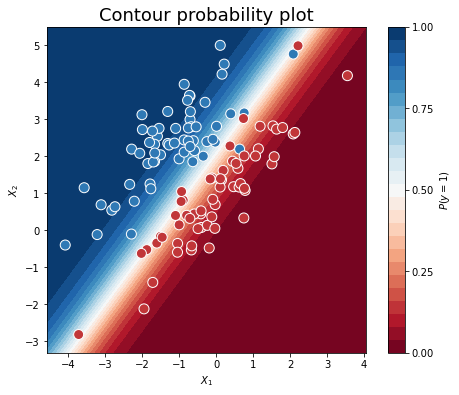

In [199]:
plot_prob_contour(model_)

## Scikit-learn

In [200]:
from sklearn.linear_model import LogisticRegression

In [201]:
model = LogisticRegression()
%time model.fit(X_train, y_train)

preds = model.predict(X_test)
accuracy = (preds == y_test).mean()
print('Accuracy = ', accuracy)

coeff =[model.intercept_, model.coef_]
print(coeff)

prob = model.predict_proba(X_test)
loss = (-y_test * np.log(prob[:,1]) - (1 - y_test) * np.log(1 - prob[:,1])).mean()
print('Loss = ', loss)

Wall time: 5 ms
Accuracy =  0.9833333333333333
[array([-7.02934932]), array([[-3.69990099,  3.21326146]])]
Loss =  0.09544108442711119


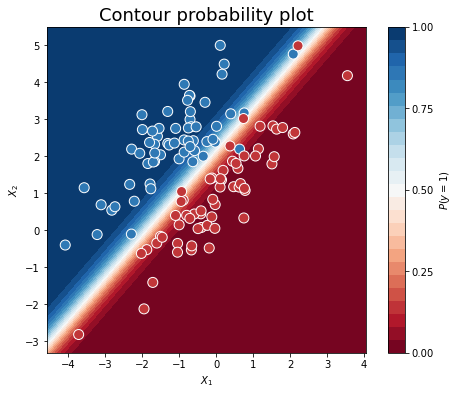

In [203]:
plot_prob_contour(model)

In [204]:
results.append(['Sklearn', accuracy, loss, model.coef_[0], model.intercept_[0]])

In [205]:
results = pd.DataFrame(results, columns = ['model_name', 'accuracy','loss', 'coefficient', 'intercept'])
results

,model_name,accuracy,loss,coefficient,intercept
0,Analytical Method,0.975000,0.140314,"[-2.6390847994481925, 2.1039187076823875]",-4.498472
1,Central Differece Formula,0.958333,0.193706,"[-2.043868782264349, 1.50515965199367]",-3.175538
2,Sklearn,0.983333,0.095441,"[-3.6999009858534366, 3.2132614573978264]",-7.029349
